<a href="https://colab.research.google.com/github/joinbuildclub/buildclub-workshops/blob/main/buildclub_agents_workshop_2025_04_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👋 **Welcome to BuildClub**

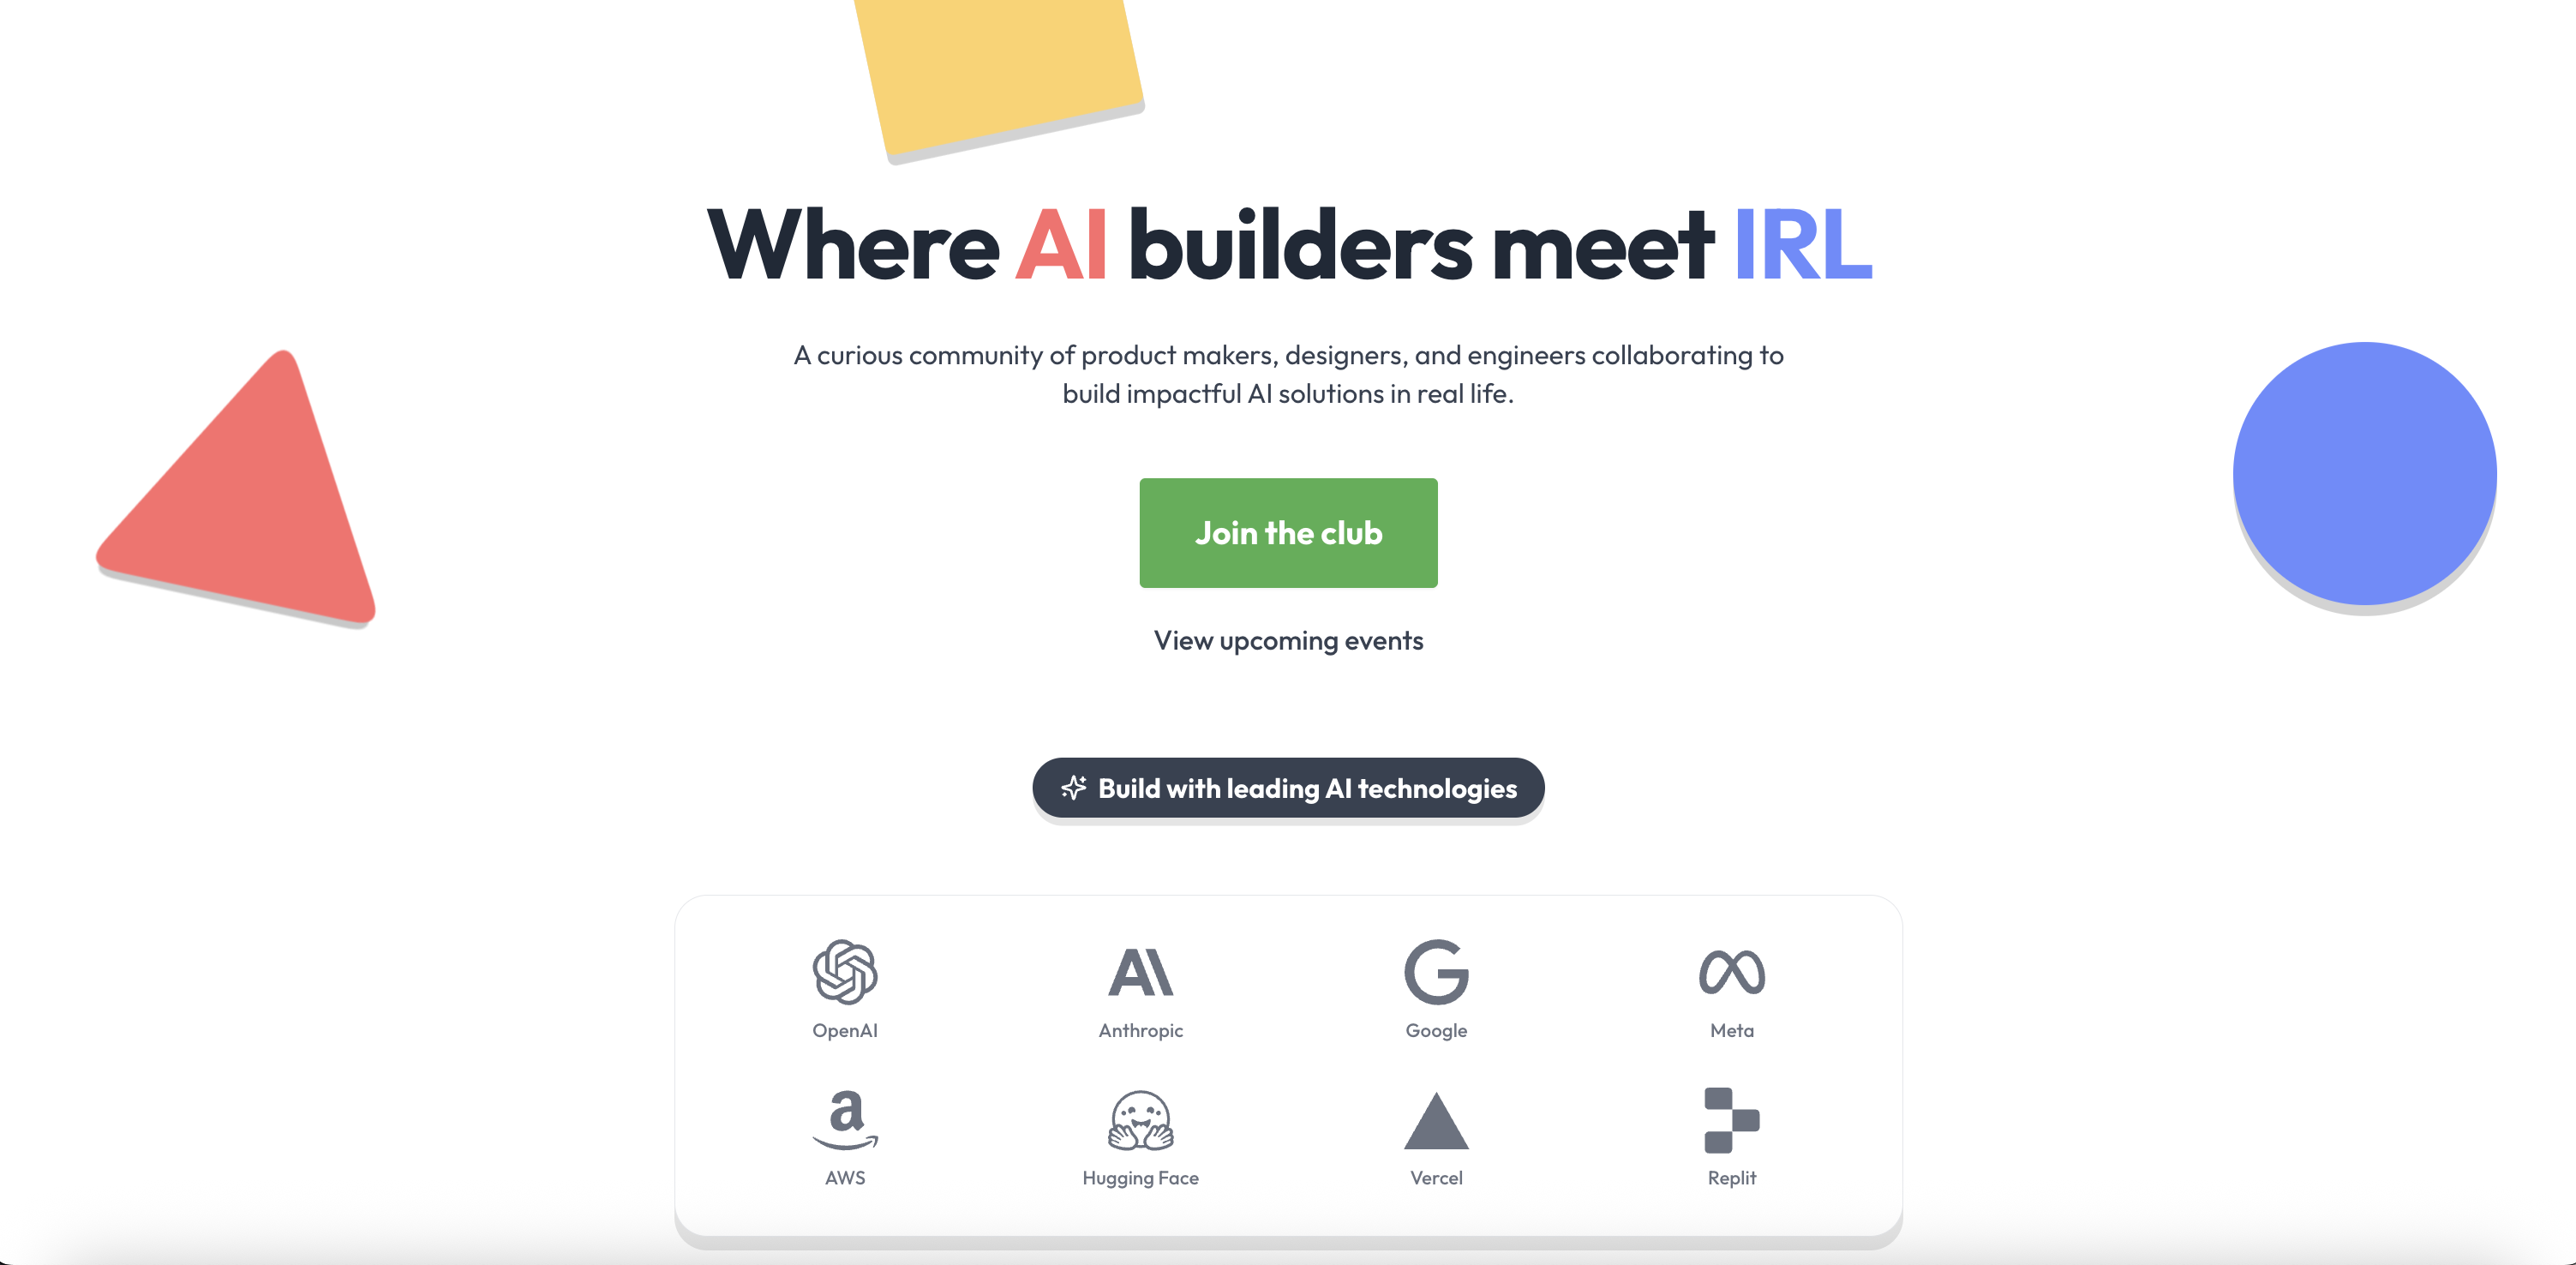

### Website
👉 https://buildclub.io

### Your Hosts
- [Tim Wheeler](https://www.linkedin.com/in/timmywheels/)
- [Ali Jobe](https://www.linkedin.com/in/ali-jobe/)
- [Emiton Alves](https://www.linkedin.com/in/emiton/)

###### **Social media**
- https://x.com/joinbuildclub
- https://linkedin.com/in/joinbuildclub
- https://instagram.com/joinbuildclub

# What we're building

Today we'll focus on build a **Market Research** agent that is capable of XYZ

## First things first -- snag an OpenAI API key

1. Start by getting an OpenAI API key here: https://platform.openai.com/settings/organization/api-keys

2. Generate an API key and copy it to your clipboard
3. Add it to the Google Colab "Secrets" tab on the left, giving it a name of `OPENAI_API_KEY`

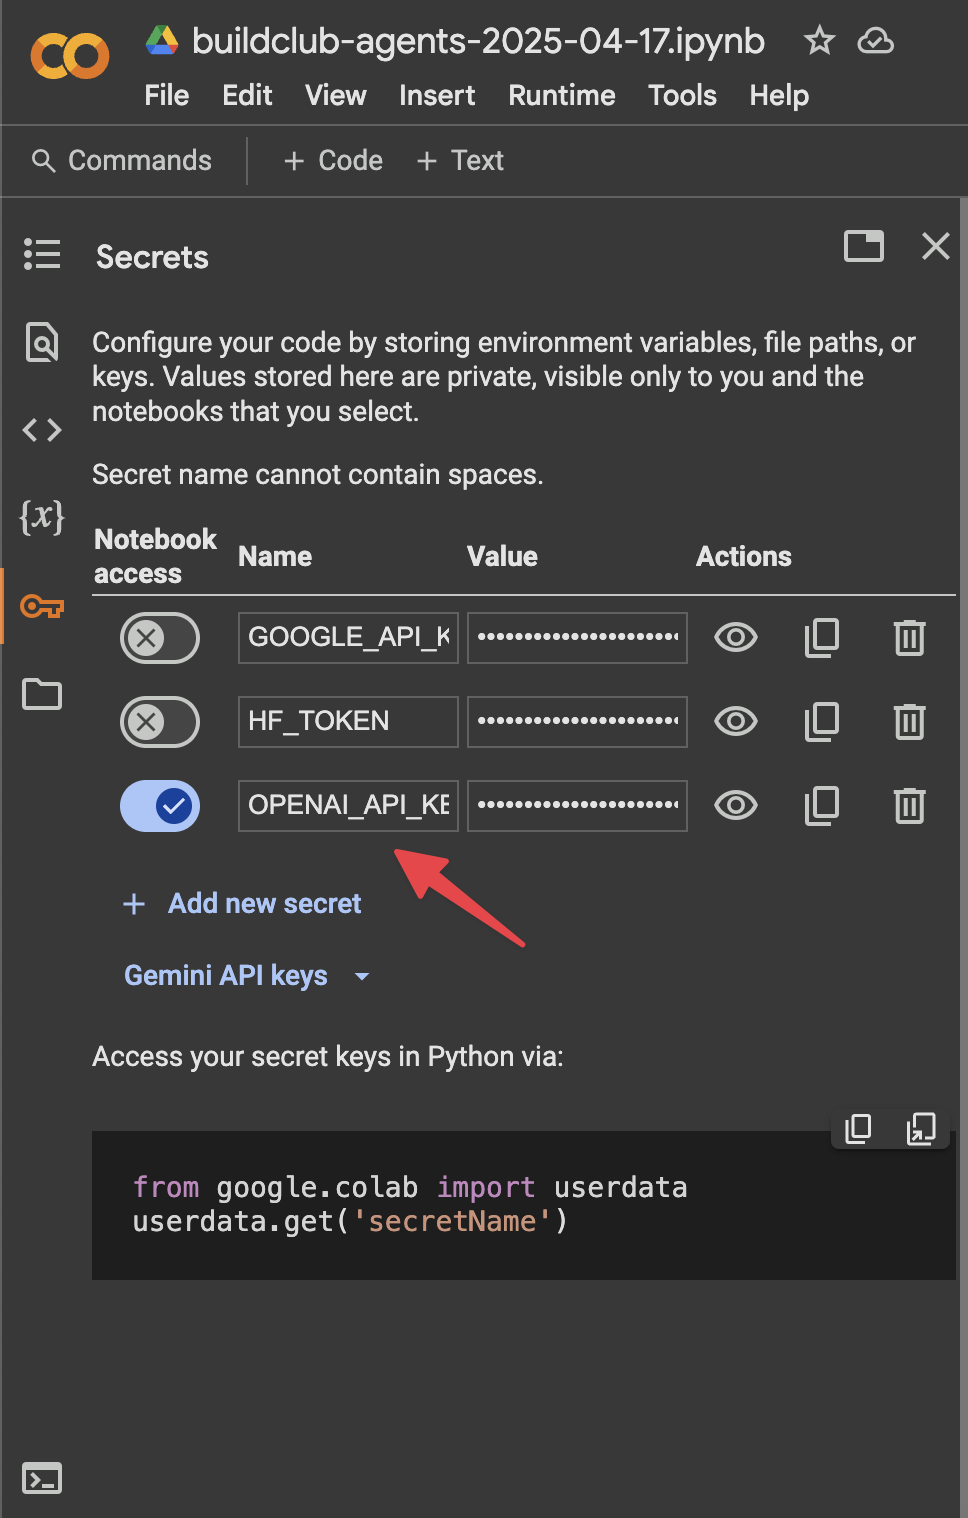

# Project Setup

## Install project dependencies

In [ ]:
pip install openai openai-agents "openai-agents[viz]" markdown bs4

## Import dependencies

In [ ]:
import os
import asyncio
from openai.types.responses import ResponseTextDeltaEvent
from agents import Agent, Runner
from google.colab import userdata
from agents.extensions.visualization import draw_graph
from agents import Agent, WebSearchTool
from agents.model_settings import ModelSettings
from pydantic import BaseModel


## Set API keys on the environment

In [ ]:
openai_api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_api_key

# Create the agents

## Create a Planner Agent

In [ ]:
# create the structured outputs / response types in JSON format
# which will take this shape

"""
{
  "searches": [
    {
      "reason": "string",
      "query": "string"
    },
    ...
  ]
}
"""

class WebSearchItem(BaseModel):
  reason: str
  "Your reasoning for why this search is important to the query."

  query: str
  "The search term to use for the web search."


class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem]
    """A list of web searches to perform to best answer the query."""

PLANNER_PROMPT = (
  "You are a helpful research assistant. Given a query, come up with a set of web searches "
  "to perform to best answer the query. Output between 5 and 20 terms to query for."
)

planner_agent = Agent(
  name="PlannerAgent",
  instructions=PLANNER_PROMPT,
  model="gpt-4o",
  output_type=WebSearchPlan,
)


## Create a Search Agent

In [ ]:
SEARCH_AGENT_PROMPT = (
    "You are a research assistant. Given a search term, you search the web for that term and"
    "produce a concise summary of the results. The summary must 2-3 paragraphs and less than 300"
    "words. Capture the main points. Write succinctly, no need to have complete sentences or good"
    "grammar. This will be consumed by someone synthesizing a report, so its vital you capture the"
    "essence and ignore any fluff. Do not include any additional commentary other than the summary"
    "itself."
)

search_agent = Agent(
    name="Search agent",
    instructions=SEARCH_AGENT_PROMPT,
    tools=[WebSearchTool()],
    model_settings=ModelSettings(tool_choice="required"),
)

## Create a Writer Agent

In [ ]:
# Agent used to synthesize a final report from the individual summaries.

WRITER_AGENT_PROMPT = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research "
    "assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 5-10 pages of content, at least 1000 words."
)


class ReportData(BaseModel):
    short_summary: str
    """A short 2-3 sentence summary of the findings."""

    markdown_report: str
    """The final report"""

    follow_up_questions: list[str]
    """Suggested topics to research further"""


writer_agent = Agent(
    name="WriterAgent",
    instructions=WRITER_AGENT_PROMPT,
    model="o3-mini",
    output_type=ReportData,
)

## Create the Printer class



In [ ]:
from typing import Any

from rich.console import Console, Group
from rich.live import Live
from rich.spinner import Spinner


class Printer:
    def __init__(self, console: Console):
        self.live = Live(console=console)
        self.items: dict[str, tuple[str, bool]] = {}
        self.hide_done_ids: set[str] = set()
        self.live.start()

    def end(self) -> None:
        self.live.stop()

    def hide_done_checkmark(self, item_id: str) -> None:
        self.hide_done_ids.add(item_id)

    def update_item(
        self, item_id: str, content: str, is_done: bool = False, hide_checkmark: bool = False
    ) -> None:
        self.items[item_id] = (content, is_done)
        if hide_checkmark:
            self.hide_done_ids.add(item_id)
        self.flush()

    def mark_item_done(self, item_id: str) -> None:
        self.items[item_id] = (self.items[item_id][0], True)
        self.flush()

    def flush(self) -> None:
        renderables: list[Any] = []
        for item_id, (content, is_done) in self.items.items():
            if is_done:
                prefix = "✅ " if item_id not in self.hide_done_ids else ""
                renderables.append(prefix + content)
            else:
                renderables.append(Spinner("dots", text=content))
        self.live.update(Group(*renderables))

## Create the Research Manager

In [ ]:
from __future__ import annotations

import asyncio
import time

from rich.console import Console

from agents import Runner, custom_span, gen_trace_id, trace


class ResearchManager:
    def __init__(self):
        self.name = "Research Manager"
        self.console = Console()
        self.printer = Printer(self.console)

    # run a task, instrumented with tracing
    # viewable from the openai dashboard
    async def run(self, query: str) -> tuple[str, list[str]]:
        trace_id = gen_trace_id()
        with trace("Research trace", trace_id=trace_id):
            self.printer.update_item(
                "trace_id",
                f"View trace: https://platform.openai.com/traces/trace?trace_id={trace_id}",
                is_done=True,
                hide_checkmark=True,
            )

            self.printer.update_item(
                "starting",
                "Starting research...",
                is_done=True,
                hide_checkmark=True,
            )
            search_plan = await self._plan_searches(query)
            search_results = await self._perform_searches(search_plan)
            report = await self._write_report(query, search_results)

            final_report = f"Report summary\n\n{report.short_summary}"
            self.printer.update_item("final_report", final_report, is_done=True)

            self.printer.end()

        # print("\n\n=====REPORT=====\n\n")
        # print(f"Report: {report.markdown_report}")
        # print("\n\n=====FOLLOW UP QUESTIONS=====\n\n")
        # follow_up_questions = "\n".join(report.follow_up_questions)
        # print(f"Follow up questions: {follow_up_questions}")
        return report

    async def _plan_searches(self, query: str) -> WebSearchPlan:
        self.printer.update_item("planning", "Planning searches...")
        result = await Runner.run(
            planner_agent,
            f"Query: {query}",
        )
        self.printer.update_item(
            "planning",
            f"Will perform {len(result.final_output.searches)} searches",
            is_done=True,
        )
        return result.final_output_as(WebSearchPlan)

    async def _perform_searches(self, search_plan: WebSearchPlan) -> list[str]:
        with custom_span("Search the web"):
            self.printer.update_item("searching", "Searching...")
            num_completed = 0
            tasks = [asyncio.create_task(self._search(item)) for item in search_plan.searches]
            results = []
            for task in asyncio.as_completed(tasks):
                result = await task
                if result is not None:
                    results.append(result)
                num_completed += 1
                self.printer.update_item(
                    "searching", f"Searching... {num_completed}/{len(tasks)} completed"
                )
            self.printer.mark_item_done("searching")
            return results

    async def _search(self, item: WebSearchItem) -> str | None:
        input = f"Search term: {item.query}\nReason for searching: {item.reason}"
        try:
            result = await Runner.run(
                search_agent,
                input,
            )
            return str(result.final_output)
        except Exception:
            return None

    async def _write_report(self, query: str, search_results: list[str]) -> ReportData:
        self.printer.update_item("writing", "Thinking about report...")
        input = f"Original query: {query}\nSummarized search results: {search_results}"
        result = Runner.run_streamed(
            writer_agent,
            input,
        )
        update_messages = [
            "Thinking about report...",
            "Planning report structure...",
            "Writing outline...",
            "Creating sections...",
            "Cleaning up formatting...",
            "Finalizing report...",
            "Finishing report...",
        ]

        last_update = time.time()
        next_message = 0
        async for _ in result.stream_events():
            if time.time() - last_update > 5 and next_message < len(update_messages):
                self.printer.update_item("writing", update_messages[next_message])
                next_message += 1
                last_update = time.time()

        self.printer.mark_item_done("writing")
        return result.final_output_as(ReportData)


# Visualizing the Agent Topology

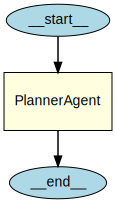

In [ ]:
draw_graph(planner_agent, filename="planner_agent_topology.png")


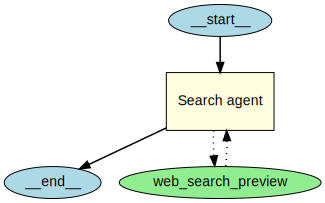

In [ ]:
draw_graph(search_agent, filename="search_agent_topology.png")

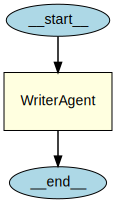

In [ ]:
draw_graph(writer_agent, filename="writer_agent_topology.png")

# Run the agent

In [ ]:
query = input("What would you like to research? ")

# initialize the research manager
research_manager = ResearchManager()

# initialize the task using the user's query
task = asyncio.create_task(research_manager.run(query))

# start the task
report = await asyncio.gather(task)

What would you like to research? what are the best startup opportunities in rhode island


Output()

# Create a Google Doc

In [ ]:
from markdown import markdown
from bs4 import BeautifulSoup
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

from googleapiclient.discovery import build
docs_service = build('docs', 'v1', credentials=creds)

markdown_report = report[0].markdown_report

html = markdown(markdown_report)
soup = BeautifulSoup(html, 'html.parser')
text = soup.get_text()

def create_google_doc(markdown_text: str):
    creds, _ = default()
    docs_service = build('docs', 'v1', credentials=creds)

    doc = docs_service.documents().create(body={'title': 'BuildClub Report'}).execute()
    doc_id = doc['documentId']

    html = markdown(markdown_text)
    soup = BeautifulSoup(html, 'html.parser')

    requests = []
    cursor = 1

    for element in soup:
        if element.name in ['h1', 'h2', 'h3']:
            text = element.get_text()
            requests.append({
                'insertText': {
                    'location': {'index': cursor},
                    'text': text + '\n'
                }
            })
            requests.append({
                'updateParagraphStyle': {
                    'range': {
                        'startIndex': cursor,
                        'endIndex': cursor + len(text) + 1
                    },
                    'paragraphStyle': {
                        'namedStyleType': f'HEADING_{min(int(element.name[1]), 3)}'
                    },
                    'fields': 'namedStyleType'
                }
            })
            cursor += len(text) + 1

        elif element.name == 'p':
            text = element.get_text()
            requests.append({
                'insertText': {
                    'location': {'index': cursor},
                    'text': text + '\n'
                }
            })
            for bold in element.find_all('strong'):
                bold_text = bold.get_text()
                start = text.find(bold_text)
                if start != -1:
                    requests.append({
                        'updateTextStyle': {
                            'range': {
                                'startIndex': cursor + start,
                                'endIndex': cursor + start + len(bold_text)
                            },
                            'textStyle': {'bold': True},
                            'fields': 'bold'
                        }
                    })
            cursor += len(text) + 1

        elif element.name == 'ul':
            for li in element.find_all('li'):
                text = li.get_text()
                requests.append({
                    'insertText': {
                        'location': {'index': cursor},
                        'text': text + '\n'
                    }
                })
                requests.append({
                    'createParagraphBullets': {
                        'range': {
                            'startIndex': cursor,
                            'endIndex': cursor + len(text) + 1
                        },
                        'bulletPreset': 'BULLET_DISC_CIRCLE_SQUARE'
                    }
                })
                cursor += len(text) + 1

    docs_service.documents().batchUpdate(
        documentId=doc_id,
        body={'requests': requests}
    ).execute()

    print(f"✅ Google Doc created: https://docs.google.com/document/d/{doc_id}/edit")

create_google_doc(markdown_report)


✅ Google Doc created: https://docs.google.com/document/d/1MY7hnvi4InTFtTnftSZ8HfUwG7629qllFydl-PZYZb0/edit


## Click that link above 👆